# Lesson 5a: Recurrent Neural Networks: Sequence Prediction

**This week's homework has two different parts: rnn_sine and rnn_divisibility. Be sure to do both!**

Each part focuses on a different type of Recurrent Neural Network architecture: prediction or classification

* 5a) **rnn_sine** (this file): Prediction of the next time point given the previous time history
* 5b) **rnn_divisibility**: Categorization of an input string

In this homework, you will create a *synthetic* dataset based on some simple mathematical functions. Then, you will design an RNN architecture that can read several function values in a row (*e.g.*, the values of the function at time points 0, 1, 2, 3, 4) and predict the next value (*e.g.*, the value of the function at time point 5).

In [163]:
%matplotlib inline

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l1_l2
import math
import numpy as np
import matplotlib.pyplot as plt

# Settings

In [164]:
NUM_LSTM_NODES = 15
NUM_EPOCHS = 10


#Set up params for dataset.
NUM_FREQS = 2      # Number of sine waves to superimpose
SR = 200           # Digital sampling rate
MAX_FREQ = SR / 2  # Nyquist frequency
two_pi = 2 * math.pi

MAX_FREQ /= 4  # calm the frequencies down a little.

MAX_X_DATA = 5     # Set x-range from 0 to MAX_X_DATA

TRAIN_TEST_SPLIT = 0.7  # Percentage of data in training set

# Use this to try on random sine waves if you'd like.
RANDOMIZE_WAVES = False
if RANDOMIZE_WAVES:
    np.random.seed(42)
    freqs = np.random.rand(NUM_FREQS) * MAX_FREQ
    amplitudes = np.random.rand(NUM_FREQS)
    phases = np.random.rand(NUM_FREQS) * two_pi
    waves = list(zip(freqs, amplitudes, phases))
else:
    # Or just use fixed frequencies etc, to make it easier:
    waves = [(20, .5, 0), (3, .3, 3)]  # Each element is (freq, amplitude, phase)
waves

[(20, 0.5, 0), (3, 0.3, 3)]

In [165]:
# Make the sine wave data.
data = []
t_list = [float(i)/SR for i in range(SR * MAX_X_DATA)]
for t in t_list:
    total = 0
    for freq, A, phase in waves:
        total += A * np.sin(phase + t * freq * two_pi)
    data.append(total)

# normalize
max_data = abs(np.max(data))
data /= max_data

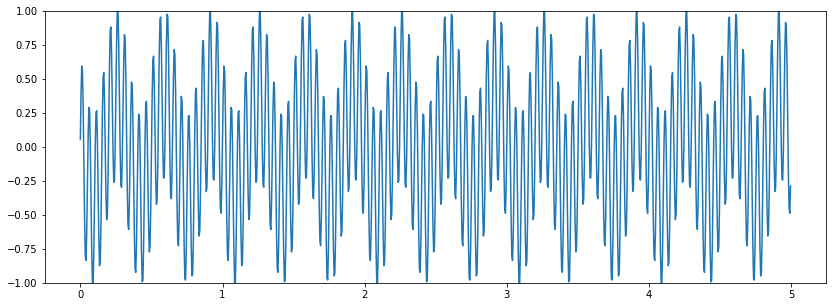

In [166]:
plt.figure(figsize=(14,5))
plt.ylim(-1,1)
plt.plot(t_list, data)
plt.show()

In [167]:
# Make input/ouput pairs: match datapoint (N) to each datapoint (N+1)
# data_pairs should be a list of data points like [(data_1, data_2), (data_2, data_3),...]
data_pairs = [(0.00, 0.5), (0.5, -0.8), (-0.8, 0.3), (0.3, -1.0), (-1.0, 0.25),(0.25, -0.82),(0.25, -0.80),(-0.80, 0.50),(0.50,-0.50), (-0.50,0.80), (0.80,-0.25), (-0.25,1.0), (1.00,-0.27), (-0.27,0.80),(-0.27,0.80), (0.80,-0.6),(-0.6,0.00)]
#data_pairs = [(0.00, 0.5), (0.5, -1.0), (-1.0, -0.75), (-0.75, 0), (0, 0.5),(0.5, 0.82),(0.82, 1.00),(1.00, 0.50),(0.50,-0.50), (-0.50,-0.80), (-0.80,-1.0), (-1.0,-0.25), (-0.25,0.5), (0.5,1.0),(1.0,0.5), (0.5,0),(0,-0.25), (-0.25, 0)]

In [168]:
split_idx = int(len(data_pairs)*TRAIN_TEST_SPLIT )
train = data_pairs[:split_idx]
test = data_pairs[split_idx:]

train_x = np.array([x[0] for x in train])
train_y = np.array([x[1] for x in train])
train_x = np.reshape(train_x, (len(train_x), 1, 1))  # batch, #prev_context, #input nodes
train_y = np.reshape(train_y, (len(train_y), 1))     # batch, #prev_context, #output nodes

test_x = np.array([x[0] for x in test])
test_y = np.array([x[1] for x in test])
test_x = np.reshape(test_x, (len(test_x), 1, 1))  # batch, #prev_context, #input nodes
test_y = np.reshape(test_y, (len(test_y), 1))     # batch, #prev_context, #output nodes

In [169]:
# Build LSTM model.

# Just an example. TODO: modify to improve performance:
data_dim = 1
timesteps = 1
batch_size = 1

model = Sequential()
model.add(LSTM(NUM_LSTM_NODES, return_sequences=True, batch_input_shape=(batch_size, timesteps, data_dim), stateful=True))
model.add(LSTM(NUM_LSTM_NODES, return_sequences=True, stateful=True))
model.add(LSTM(NUM_LSTM_NODES, stateful=True))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

# compile model
model.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (1, 1, 15)                1020      
_________________________________________________________________
lstm_39 (LSTM)               (1, 1, 15)                1860      
_________________________________________________________________
lstm_40 (LSTM)               (1, 15)                   1860      
_________________________________________________________________
dense_27 (Dense)             (1, 5)                    80        
_________________________________________________________________
dense_28 (Dense)             (1, 1)                    6         
Total params: 4,826
Trainable params: 4,826
Non-trainable params: 0
_________________________________________________________________


In [170]:
# fit model
for i in range(NUM_EPOCHS):
    print("Epoch %d" % i)
    model.fit(train_x, train_y, batch_size=1, epochs=5, shuffle=False, verbose=1)
    model.reset_states()

Epoch 0
Epoch 1/5
11/11 [==============================] - 3s 269ms/step - loss: 0.4141
Epoch 2/5
11/11 [==============================] - 0s 14ms/step - loss: 0.4087
Epoch 3/5
11/11 [==============================] - 0s 14ms/step - loss: 0.4044
Epoch 4/5
11/11 [==============================] - 0s 14ms/step - loss: 0.4003
Epoch 5/5
11/11 [==============================] - 0s 14ms/step - loss: 0.3964
Epoch 1
Epoch 1/5
11/11 [==============================] - 0s 15ms/step - loss: 0.3970
Epoch 2/5
11/11 [==============================] - 0s 14ms/step - loss: 0.3900
Epoch 3/5
11/11 [==============================] - 0s 14ms/step - loss: 0.3861
Epoch 4/5
11/11 [==============================] - 0s 14ms/step - loss: 0.3835
Epoch 5/5
11/11 [==============================] - 0s 15ms/step - loss: 0.3816
Epoch 2
Epoch 1/5
11/11 [==============================] - 0s 15ms/step - loss: 0.3859
Epoch 2/5
11/11 [==============================] - 0s 14ms/step - loss: 0.3803
Epoch 3/5
11/11 [==========

In [171]:
# Evaluate accuracy
scores = model.evaluate(test_x, test_y, batch_size=1, verbose=0)
model.reset_states()
print("Model Accuracy: %.2f%%" % (scores*100))

Model Accuracy: 92.89%


## Make predictions with the model

In [172]:
result = []
for i in range(len(test_x)):
    prediction = model.predict(test_x[i].reshape(1,1,1), verbose=0)
    result.append([prediction, test_y[i]])
model.reset_states()  # Do this after giving an input sequence, to clear out hidden states.

In [173]:
predictions = [[x[0][0][0], x[1][0]] for x in result]

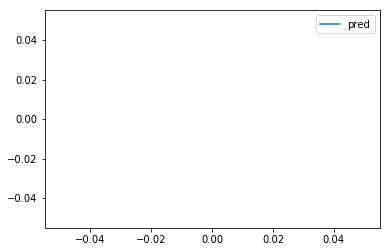

In [174]:
plt.plot(predictions[50:150])
plt.legend(('pred', 'actual'))
plt.show()

In [175]:
errors = [abs(x[1] - x[0]) for x in predictions]

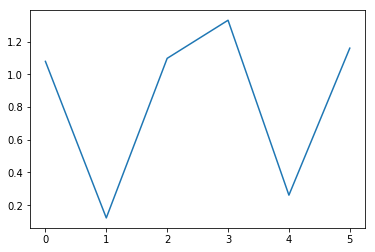

In [176]:
plt.plot(errors)
plt.show()

## Question 1: Discuss the results. How accurate was the model? What did you do to improve its accuracy? What problems did you run into?

In [ ]:
The model is 92.89%

1. To improve the model I stacked three layers one after the other.
2. I am using fixed frequency wave. I tried different epoch to improve the model. With epoch of 5, I am getting good accuracy
3. Initially I used less number of input samples for the sine wave inputs, then I was getting low accuracy of around 50%, then I 
tried with more samples that match the input wave, then I got better accuracy
4. With this data points, I tried for Randomized wave, I got only accuracy of 50%.

## Question 2: What problems did you run into, if any?

In [ ]:
Initially I tried try with different timesteps and batch_size, but then I started to get more errors. So, I used the given
timesteps and batch_size.

